In [1]:
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg  # For rendering
!pip install pyvirtualdisplay
!pip install gymnasium[mujoco]         # Gymnasium + MuJoCo support
!pip install stable-baselines3         # RL library
!apt-get update
!apt-get install -y xvfb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,315 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,677 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-upda

In [2]:
import gymnasium as gym
import os
import pandas as pd
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize, VecVideoRecorder
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed

from pyvirtualdisplay import Display
from IPython.display import HTML
from base64 import b64encode


In [3]:
# Start virtual display for video rendering in Colab
display = Display(visible=0, size=(800, 600))
display.start()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env_id = "Reacher-v5"

# Directories for logs
train_log_dir = "logs/train_logs"
eval_log_dir = "logs/eval_logs"

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(eval_log_dir, exist_ok=True)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def make_custom_env(seed=0):
    env = gym.make(
        env_id,
        reward_control_weight=0.0,
        render_mode="rgb_array"
    )
    # 1) Unwrap the default TimeLimit
    env = env.unwrapped

    # 2) Override the environment spec
    env.spec.max_episode_steps = 200

    # 3) Now wrap it with your own TimeLimit
    env = gym.wrappers.TimeLimit(env, max_episode_steps=200)

    # Optional: use Monitor for logging (Training logs)
    monitor_file = os.path.join(train_log_dir, f"monitor_train_{seed}.csv")
    env = Monitor(env, filename=monitor_file)

    env.reset(seed=seed)
    return env


In [6]:
num_envs = 12  # Try 12 parallel environments

def make_env_fn(rank):
    """
    A helper to create environment with different seeds
    to ensure more diverse experiences.
    """
    def _init():
        env_ = make_custom_env(seed=123 + rank)
        return env_
    return _init

# SubprocVecEnv for parallelization (faster than DummyVecEnv if available)
env_fns = [make_env_fn(i) for i in range(num_envs)]
vec_env = SubprocVecEnv(env_fns)

In [7]:
vec_env = VecNormalize(
    vec_env,
    norm_obs=True,     # Normalize observations
    norm_reward=False, # Keep rewards in original scale
    clip_obs=10.0
)

In [8]:
model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    # A good start for MuJoCo-like tasks:
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=3e-4,
    ent_coef=0.0,      # Entropy cost coefficient (can help exploration if > 0)
    clip_range=0.2
)

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [9]:
total_timesteps = 500_000_0
model.learn(total_timesteps=total_timesteps)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -34.7    |
| time/              |          |
|    fps             | 2652     |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 24576    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -33.9       |
| time/                   |             |
|    fps                  | 2128        |
|    iterations           | 2           |
|    time_elapsed         | 23          |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.005248815 |
|    clip_fraction        | 0.0425      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.126      |
|    learning_rate        | 0.

In [10]:
model.save("ppo_reacher")
vec_env.save("vec_normalize.pkl")


In [11]:
def make_eval_env():
    # Create environment specifically for evaluation
    test_env = gym.make(
        env_id,
        reward_control_weight=0.0,
        render_mode="rgb_array"
    )
    test_env = test_env.unwrapped
    test_env.spec.max_episode_steps = 200
    test_env = gym.wrappers.TimeLimit(test_env, max_episode_steps=200)

    # Write to separate evaluation log file
    monitor_file_eval = os.path.join(eval_log_dir, "monitor_eval.csv")
    test_env = Monitor(test_env, filename=monitor_file_eval)

    test_env.reset(seed=999)

    # Wrap it with the same VecNormalize config, but in eval mode
    eval_vec_env = DummyVecEnv([lambda: test_env])
    eval_vec_env = VecNormalize.load("vec_normalize.pkl", eval_vec_env)
    eval_vec_env.training = False
    eval_vec_env.norm_reward = False

    return eval_vec_env

# Now instantiate the actual evaluation environment
eval_env = make_eval_env()

video_folder = "videos"
os.makedirs(video_folder, exist_ok=True)
video_length = 5000 #10000  # Number of timesteps for the video

eval_env = VecVideoRecorder(
    eval_env,
    video_folder,
    record_video_trigger=lambda step: step == 0,
    video_length=video_length,
    name_prefix="reacher_test"
)

obs = eval_env.reset()

episode_count = 1
episode_timesteps = 0

# Because we are using a vectorized environment with only 1 environment inside,
# `done` will be an array of shape (1,), so we'll check `done[0]`.
for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = eval_env.step(action)
    episode_timesteps += 1

    if dones[0]:
        print(f"Episode {episode_count} ended after {episode_timesteps} timesteps.")
        episode_count += 1
        episode_timesteps = 0
        obs = eval_env.reset()


Episode 1 ended after 200 timesteps.
Episode 2 ended after 200 timesteps.
Episode 3 ended after 200 timesteps.
Episode 4 ended after 200 timesteps.
Episode 5 ended after 200 timesteps.
Episode 6 ended after 200 timesteps.
Episode 7 ended after 200 timesteps.
Episode 8 ended after 200 timesteps.
Episode 9 ended after 200 timesteps.
Episode 10 ended after 200 timesteps.
Episode 11 ended after 200 timesteps.
Episode 12 ended after 200 timesteps.
Episode 13 ended after 200 timesteps.
Episode 14 ended after 200 timesteps.
Episode 15 ended after 200 timesteps.
Episode 16 ended after 200 timesteps.
Episode 17 ended after 200 timesteps.
Episode 18 ended after 200 timesteps.
Episode 19 ended after 200 timesteps.
Episode 20 ended after 200 timesteps.
Episode 21 ended after 200 timesteps.
Episode 22 ended after 200 timesteps.
Episode 23 ended after 200 timesteps.
Episode 24 ended after 200 timesteps.
Saving video to /content/videos/reacher_test-step-0-to-step-5000.mp4


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/reacher_test-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/videos/reacher_test-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/reacher_test-step-0-to-step-5000.mp4
Episode 25 ended after 200 timesteps.


In [12]:
import pandas as pd
import os
import re  # for parsing the seed from filenames

def export_training_rewards_to_excel(output_filename="training_rewards.xlsx"):
    train_monitor_files = [
        f for f in os.listdir(train_log_dir)
        if f.startswith("monitor_train_") and f.endswith(".csv")
    ]

    if not train_monitor_files:
        print("No training monitor files found in", train_log_dir)
        return

    series_list = []

    for filename in train_monitor_files:
        # Example filename: "monitor_train_123.csv"
        # Extract the seed (e.g. 123)
        match = re.search(r"monitor_train_(\d+)\.csv", filename)
        if match:
            seed_str = match.group(1)  # e.g. "123"
        else:
            # Fallback if the filename doesn't match the pattern
            seed_str = filename

        filepath = os.path.join(train_log_dir, filename)
        df = pd.read_csv(filepath, skiprows=1)  # skip the first metadata row

        # df columns are typically: r, l, t
        # We only want the 'r' column (the total reward)
        rewards = df["r"].copy()

        # Rename it to the seed (for the column name)
        # We'll make it a pandas Series with a nice name
        rewards.name = f"seed_{seed_str}"

        # Index from 1..N episodes for clarity
        rewards.index = range(1, len(rewards) + 1)

        series_list.append(rewards)

    # Combine them side-by-side
    combined_df = pd.concat(series_list, axis=1)

    # Save to Excel
    combined_df.to_excel(output_filename, index_label="Episode")
    print(f"Training rewards exported to Excel: {output_filename}")


# Actually run the export
export_training_rewards_to_excel("training_rewards.xlsx")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training rewards exported to Excel: training_rewards.xlsx


🏆 Best Reward Achieved (Training): -0.29 at Episode 12496


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


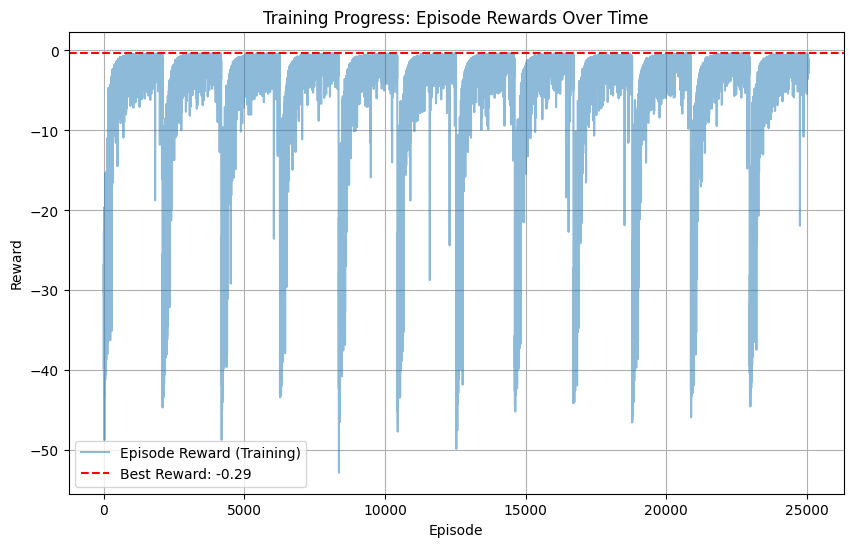

In [13]:
train_monitor_files = [
    f for f in os.listdir(train_log_dir)
    if f.startswith("monitor_train_") and f.endswith(".csv")
]

if len(train_monitor_files) > 0:
    combined_data = []
    for mf in train_monitor_files:
        filepath = os.path.join(train_log_dir, mf)
        df = pd.read_csv(filepath, skiprows=1)
        combined_data.append(df)
    data = pd.concat(combined_data, ignore_index=True)

    best_reward = data["r"].max()
    best_episode = data["r"].idxmax() + 1
    print(f"🏆 Best Reward Achieved (Training): {best_reward:.2f} at Episode {best_episode}")

    # Plot the raw rewards
    plt.figure(figsize=(10, 6))
    plt.plot(data["r"], label="Episode Reward (Training)", alpha=0.5)
    plt.axhline(best_reward, color='red', linestyle='--', label=f'Best Reward: {best_reward:.2f}')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Progress: Episode Rewards Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No training monitor files found in train_log_dir.")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
